<img src="https://shwetkm.github.io/upxlogo.png"></img>

In this notebook, you'll perform a time series analysis using the **Autoregressive Integrated Moving Average (ARIMA)** modeling technique in Python. ARIMA modeling, in theory, is the most general class of models for forecasting a time series.

## **What is Time Series**

A time series is a collection of data points that are collected at constant time intervals. What differentiates a time series from regular regression problem data is that the observations are time dependent and, along with an increasing or decreasing trend, many time series exhibit seasonal trends. 

The ARIMA technique seeks to model these trends in data over time and then extrapolate into the future to obtain forecasts. Time series modeling is a powerful method to derive insights from time-based data and make informed decisions about future trends.

### Today's Activity

You will analyze data from _**Quandl**_. The data describes the Bank of England's official statistics on spot exchange rates for the Euro into US dollars (USD). 

More information on the the data source and Euro exchange rates prior to 1999 can be found here
http://www.bankofengland.co.uk/statistics/pages/iadb/notesiadb/Spot_rates.aspx


In [218]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [219]:
df_fx_data = pd.read_csv("BOE-XUDLERD.csv")
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])  #convert the Pandas DataFrame into a time series with daily frequency
indexed_df = df_fx_data.set_index('Date')

In [220]:
#converting dataframe to panda series
ts = indexed_df['Value']
ts.head(5)

Date
2017-03-24    0.9255
2017-03-23    0.9270
2017-03-22    0.9258
2017-03-21    0.9252
2017-03-20    0.9300
Name: Value, dtype: float64

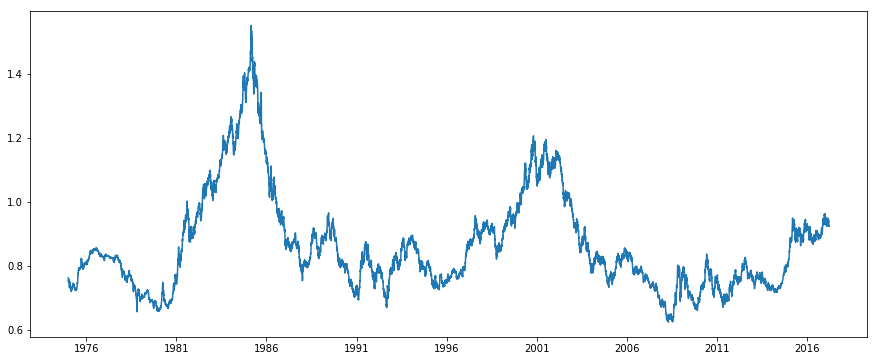

In [221]:
#Visualize the time series to see how the Euro is trending against the US dollar over time:
plt.plot(ts)

### Resample the Data
Using daily data for your time series contains too much variation, so you must first resample the time series data by week. Then use this resampled time series to predict the Euro exchange rates against the US Dollar:

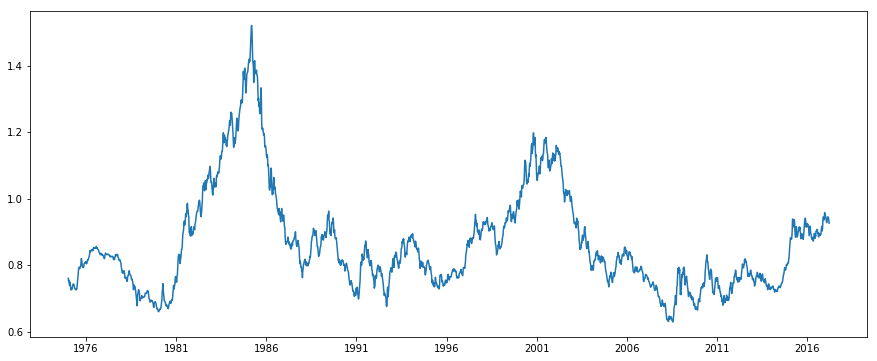

In [222]:
ts_week = ts.resample('W').mean() #resampling by week
plt.plot(ts_week)

In [223]:
ts_week.head() #check the Freq:

Date
1975-01-05    0.76090
1975-01-12    0.75346
1975-01-19    0.75546
1975-01-26    0.74388
1975-02-02    0.73902
Freq: W-SUN, Name: Value, dtype: float64

### Plotting Simple Miving Average

C:\Users\mohad\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  from ipykernel import kernelapp as app


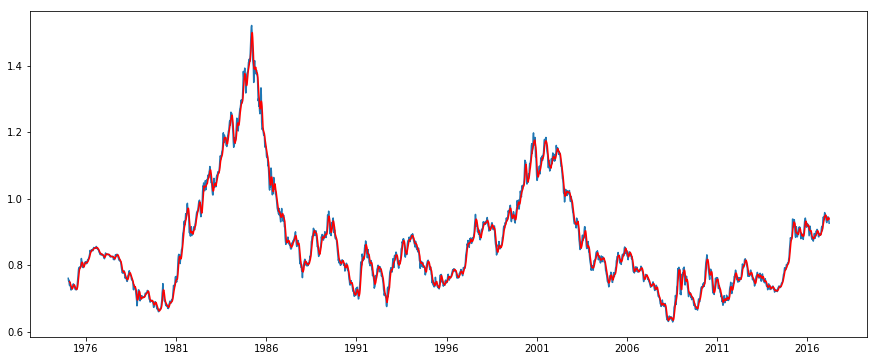

In [224]:
#taking the moving average of 20 points and plotting
moving_avg = pd.rolling_mean(ts_week,5)
plt.plot(ts_week)
plt.plot(moving_avg, color='red')

### Plotting Exponential Moving Average

C:\Users\mohad\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=12,min_periods=0,adjust=True,ignore_na=False).mean()
  from ipykernel import kernelapp as app


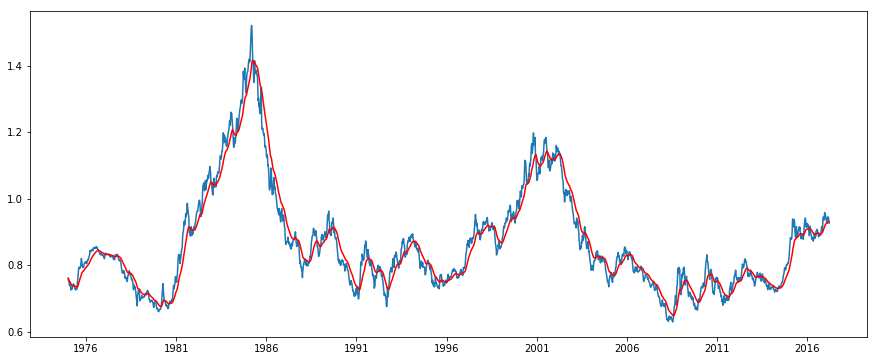

In [225]:
#plotting with exponential moving average
exp_moving_avg = pd.ewma(ts_week,12)
plt.plot(ts_week)
plt.plot(exp_moving_avg, color='red')

In a stationary time series, the statistical properties over time must be constant and autoconvariance must be time independent. Normally, when running a regular regression, you expect the observations to be independent of each other. 

_**In a time series, however, you know that the observations are time dependent. In order to use regression techniques on time dependent variables, the data must be stationary. The techniques that apply to independent random variables also apply to stationary random variables.**_

There are two ways to check the stationarity of a time series. The first is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences. The second way is to use the **Dickey-Fuller test**, a statistical test with the null hypothesis that the time series is non-stationary.

_**If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.**_

In [226]:

#ceating a function to test wheather the time series is stationary or not
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

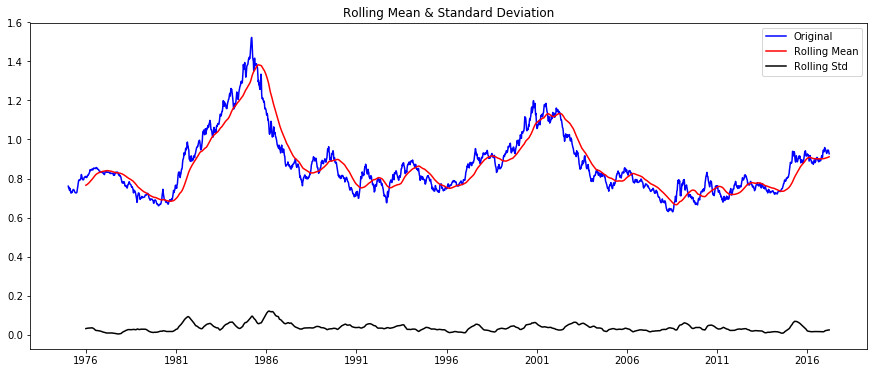

Results of Dickey-Fuller Test:
Test Statistic                   -2.037007
p-value                           0.270586
#Lags Used                        2.000000
Number of Observations Used    2201.000000
Critical Value (1%)              -3.433325
Critical Value (5%)              -2.862854
Critical Value (10%)             -2.567470
dtype: float64


In [227]:
test_stationarity(ts_week)

## Stationarize the time series
Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

One can apply different transformations to stationarize the data
http://people.duke.edu/~rnau/whatuse.htm

Let's apply a simple, nonlinear log transformation


In [228]:
ts_week_log = np.log(ts_week)

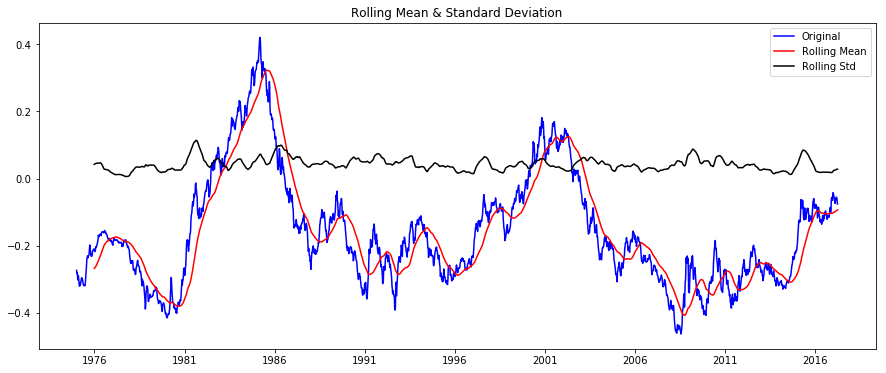

Results of Dickey-Fuller Test:
Test Statistic                   -2.189216
p-value                           0.210183
#Lags Used                        1.000000
Number of Observations Used    2202.000000
Critical Value (1%)              -3.433323
Critical Value (5%)              -2.862853
Critical Value (10%)             -2.567469
dtype: float64


In [229]:
test_stationarity(ts_week_log)

**The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05.**

### Remove trend and seasonality with decomposition
Next, decompose the time series to remove trend and seasonality from the data. Decomposition results show an increasing trend and seasonal effect of approximately a 12 month cycle for the more recent weeks in the data set.

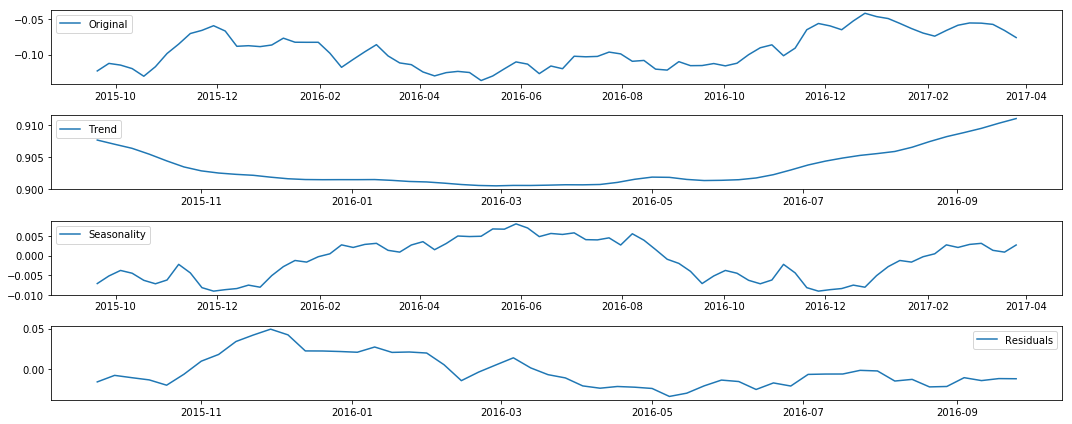

In [230]:
decomposition = seasonal_decompose(ts_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_week_log[-80:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[-80:], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[-80:],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[-80:], label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Remove trend and seasonality with differencing

Remove trend and seasonality with first order differencing, you compute the differences between consecutive observations in the time series. This usually improves the stationarity of the time series. 

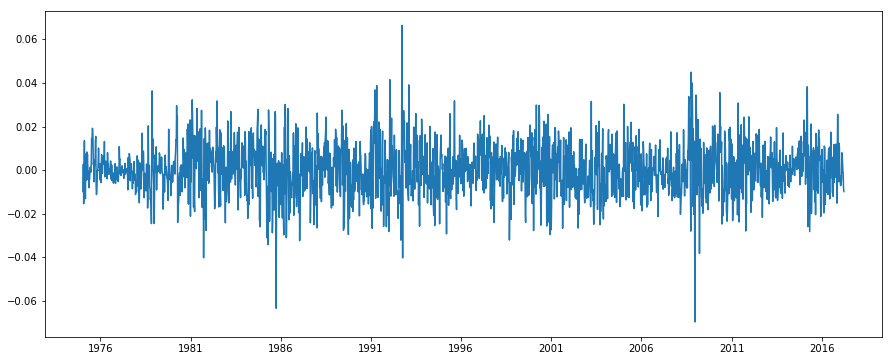

In [231]:
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

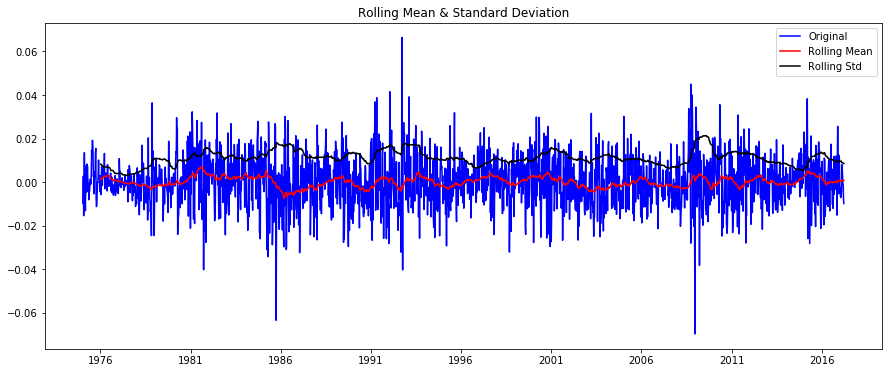

Results of Dickey-Fuller Test:
Test Statistic                  -36.330494
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2202.000000
Critical Value (1%)              -3.433323
Critical Value (5%)              -2.862853
Critical Value (10%)             -2.567469
dtype: float64


In [232]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

### Find optimal parameters and build an ARIMA model
To apply an ARIMA model to your time series, you need to find optimal values for the following three model parameters (p,d,q):

1. The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable, the euro rate, in this case. So, if p=2, it means that predictors of x(t) will be x(t-1) and x(t-2).

2. The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation. For instance, if q=2, the predictors for x(t) will be e(t-1) and e(t-2) where e(i) is the difference between the moving average at i-th instant and the actual value.

3. The number of differences (d): These are the number of non-seasonal differences. In your case, d=1, as you are modeling using the first order differenced time series.

Plots of the autocorrelation function (ACF) and partial autocorrelation function (PACF) can be used to find p and q333.

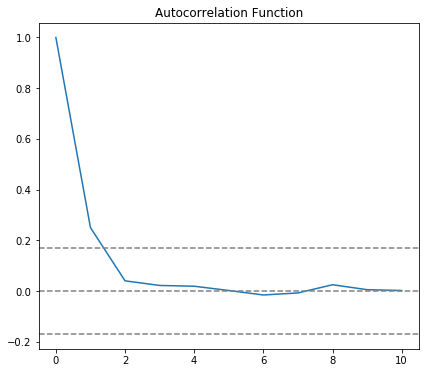

In [235]:
#Plot ACF: 

lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

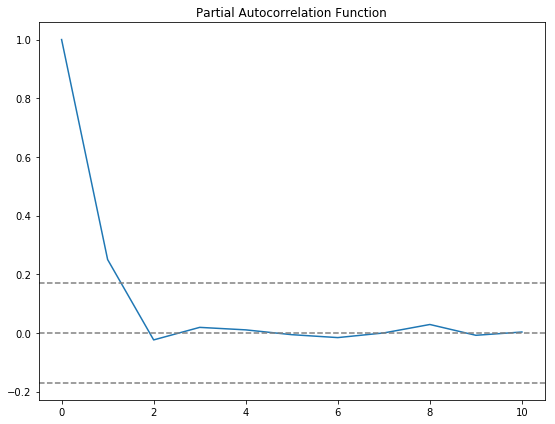

In [236]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the 'p' and 'q' values can be determined as follows:

1. p: The lag value where the PACF cuts off (drops to 0) for the first time. If you look closely, p=2.

2. q: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you look closely, q=1.

This means that the optimal values for the ARIMA(p,d,q) model are (2,1,1).

Residual sum of square error:  nan


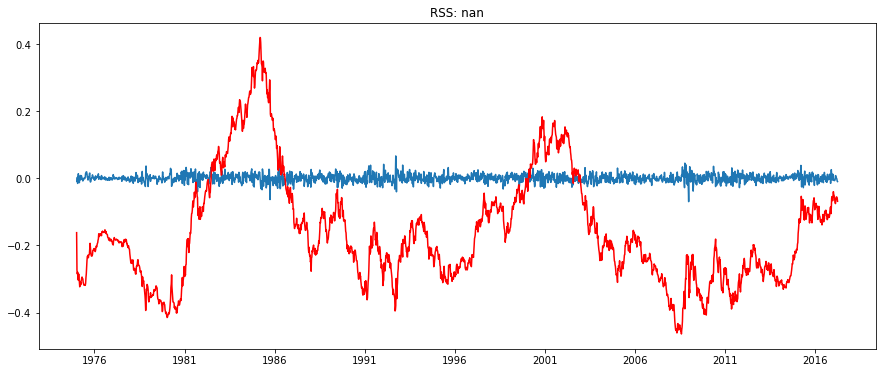

In [238]:
#AR model

model = ARIMA(ts_week_log, order=(2, 0, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red') #residual sum of squares
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))
print("Residual sum of square error: ",sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

Residual sum of square error:  nan


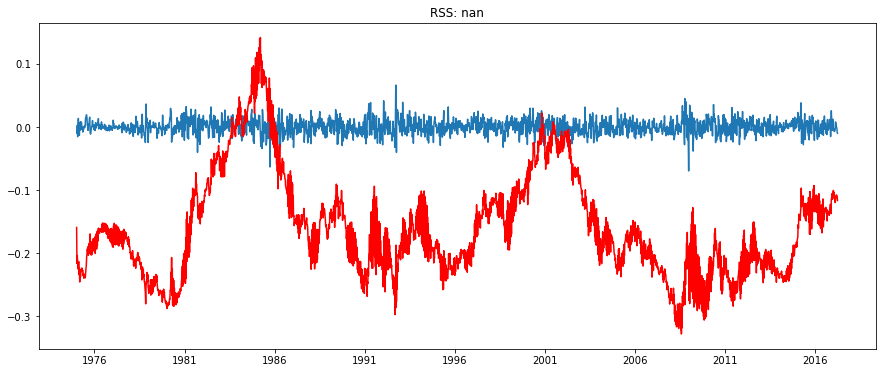

In [239]:
#MA model
model = ARIMA(ts_week_log, order=(0, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red') #residual sum of squares
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))
#print("Residual sum of square error: ",sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))

Residual sum of square error:  0.278563834692


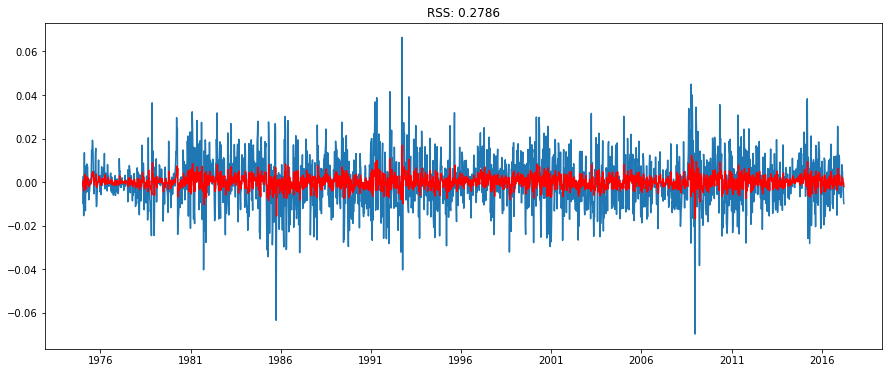

In [241]:
#arima model
model = ARIMA(ts_week_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red') #residual sum of squares
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))
print("Residual sum of square error: ",sum((results_ARIMA.fittedvalues-ts_week_log_diff)**2))